# Финальный проект: вариант 1

In [68]:
#импортируем все библиотеки, которые понадобятся нам для выполнения проекта
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from tqdm.auto import tqdm

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [69]:
#считываем исходные данные и записываем их в датафреймы с аналогичными названиями
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-davydova/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-davydova/shared/problem1-auth_data.csv', sep=';')

Сперва проведём разведочный анализ данных - изучим предоставленные исходные данные.

Посмотрим на количество записей в каждом датасете и проверим на наличие дубликатов:

In [70]:
reg_data.shape #проверяем размер датафрейма reg_data

(1000000, 2)

In [71]:
reg_data = reg_data.drop_duplicates()
reg_data.shape
#Как видим, данные о времени регистрации не содержат дубликатов

(1000000, 2)

In [72]:
auth_data.shape #проверяем размер датафрейма auth_data

(9601013, 2)

In [73]:
auth_data = auth_data.drop_duplicates()
auth_data.shape
#Как видим, данные о времени захода пользователей в игру не содержат дубликатов

(9601013, 2)

Проверим информацию о столбцах наших датафреймов с помощью метода df.info

In [74]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 22.9 MB


In [75]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 219.7 MB


В столбцах датафреймов нет пропущенных значений, однако заметим, что столбцы с датами (reg_ts и auth_ts) имеют тип данных int64.

Посмотрим, как выглядят эти даты в самих таблицах.

In [76]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [77]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Похоже, что время в исходных датафреймах указано как число секунд, прошедших с 1970 года. Для нас это неудобно и нечитабельно, поэтому сконвертируем даты в human-readable формат.

In [78]:
reg_data['reg_ts']   = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

Проверим, изменился ли тип данных в столбцах с датами на на datetime64[ns]:

In [79]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [80]:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

Получилось. Теперь посмотрим, стали ли выглядеть сами даты в таблицах читабельнее:

In [81]:
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [82]:
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


Нам не важны часы, минуты и секудны как моментов совершения регистрации, так и каждой сессии пользователей, поэтому приведём колонки reg_ts и auth_ts в датафреймах к виду "год-месяц-день", используя .dt.to_period("D").

In [83]:
reg_data['reg_ts']  = reg_data.reg_ts.dt.to_period("D")
auth_data['auth_ts'] = auth_data.auth_ts.dt.to_period("D")

Проверяем, как теперь выглядят даты:

In [84]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [85]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


Отлично. Теперь данные готовы к дальнейшему использованию в решении поставленных задач.

Так как требуется рассчитать показатель retention, необходимо будет иметь под рукой информацию как о дате посещения игры каждым пользователем, так и о дате его регистрации в игре. Для этого объединим таблицы с данными о времени регистрации и о времени захода пользователей в игру по уникальному номеру пользователя (uid), используя метод merge.

In [86]:
full_data = reg_data.merge(auth_data, how='left', on='uid')

In [87]:
full_data.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [88]:
#Проверим, что не потеряли каких-то пользователей
full_data.shape

(9601013, 3)

Всё верно, кол-во строк совпадает с датафреймом auth_data, содержащем информацию о каждой сессии пользователя, а кол-во столбцов увеличилось, т.к. прибавился столбец с датой регистрации из reg_data.

Получившийся датафрейм довольно тяжёлый, так как содержит информацию о более чем 9.5 млн игровых сессий. Проверим, какая была самая ранняя и самая поздняя дата регистрации в нашей игре.

In [89]:
full_data.reg_ts.min()

Period('1998-11-18', 'D')

In [90]:
full_data.reg_ts.max()

Period('2020-09-23', 'D')

Охваченный временной промежуток довольно большой. Автором работы принято решение при рассчёте показателя retention использовать  данные с регистациями за последний полный месяц, а именно за август 2020-го года. Отбираем эти данные:

In [91]:
full_data = full_data.query('reg_ts >= "2020-08-01" &  reg_ts <= "2020-08-31"')

In [92]:
full_data

,reg_ts,uid,auth_ts
9428605,2020-08-01,1016863,2020-08-01
9428606,2020-08-01,1016863,2020-08-06
9428607,2020-08-01,1016863,2020-08-11
9428608,2020-08-01,1016863,2020-08-15
9428609,2020-08-01,1016863,2020-08-18
...,...,...,...
9545198,2020-08-31,1070030,2020-09-15
9545199,2020-08-31,1070030,2020-09-22
9545200,2020-08-31,1070031,2020-08-31
9545201,2020-08-31,1070032,2020-08-31


Пришло время формировать когорты. Сгруппируем данные по дате регистации (когорте), а затем по дате сессии для каждого пользователя, и посчитаем количество активных пользователей. Полученный датафрейм назовём cohorts.

In [93]:
cohorts = full_data.groupby(['reg_ts', 'auth_ts']).agg({'uid':'count'})
cohorts

uid
reg_ts     auth_ts         
2020-08-01 2020-08-01  1507
           2020-08-02    29
           2020-08-03    67
           2020-08-04    65
           2020-08-05    84
...                     ...
2020-08-31 2020-09-19    72
           2020-09-20    55
           2020-09-21    63
           2020-09-22    44
           2020-09-23    30

[1209 rows x 1 columns]

Добавим порядковое значение CohortPeriod для каждой сессии. CohortPeriod определим как порядковый номер дня в массиве, начинающийся с 0.

In [94]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts

uid  cohort_period
reg_ts     auth_ts                        
2020-08-01 2020-08-01  1507              0
           2020-08-02    29              1
           2020-08-03    67              2
           2020-08-04    65              3
           2020-08-05    84              4
...                     ...            ...
2020-08-31 2020-09-19    72             19
           2020-09-20    55             20
           2020-09-21    63             21
           2020-09-22    44             22
           2020-09-23    30             23

[1209 rows x 2 columns]

Теперь сформируем сводную таблицу, которая будет более наглядно интерпретировать результат.

In [95]:
cohorts_pivot = cohorts.pivot_table(index='reg_ts', columns='cohort_period', values='uid')
cohorts_pivot

cohort_period,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507.0,29.0,67.0,65.0,84.0,89.0,115.0,96.0,68.0,96.0,...,27.0,21.0,27.0,11.0,14.0,24.0,24.0,18.0,19.0,13.0
2020-08-02,1509.0,39.0,61.0,66.0,78.0,98.0,100.0,91.0,68.0,80.0,...,22.0,16.0,20.0,19.0,20.0,16.0,25.0,21.0,6.0,NaN
2020-08-03,1512.0,26.0,65.0,61.0,84.0,93.0,114.0,80.0,75.0,74.0,...,30.0,27.0,23.0,22.0,23.0,17.0,15.0,14.0,NaN,NaN
2020-08-04,1514.0,31.0,54.0,71.0,79.0,80.0,98.0,78.0,67.0,71.0,...,25.0,26.0,20.0,20.0,22.0,15.0,12.0,NaN,NaN,NaN
2020-08-05,1517.0,39.0,53.0,61.0,87.0,77.0,118.0,93.0,64.0,72.0,...,19.0,24.0,10.0,16.0,16.0,8.0,NaN,NaN,NaN,NaN
2020-08-06,1519.0,26.0,77.0,87.0,85.0,87.0,114.0,92.0,76.0,88.0,...,18.0,17.0,17.0,15.0,17.0,NaN,NaN,NaN,NaN,NaN
2020-08-07,1522.0,33.0,47.0,80.0,81.0,91.0,109.0,94.0,78.0,76.0,...,20.0,22.0,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1524.0,37.0,73.0,64.0,83.0,83.0,110.0,96.0,60.0,73.0,...,21.0,15.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1527.0,32.0,60.0,71.0,82.0,108.0,96.0,101.0,68.0,75.0,...,27.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Запишем в all исходное кол-во пользователей в день регистрации для каждой когорты.

In [96]:
all = cohorts_pivot[0]

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из дней на исходное кол-во пользователей в когорте.

In [97]:
user_retention = cohorts_pivot.divide(all, axis=0)
user_retention

cohort_period,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1.0,0.019244,0.044459,0.043132,0.055740,0.059058,0.076311,0.063703,0.045123,0.063703,...,0.017916,0.013935,0.017916,0.007299,0.009290,0.015926,0.015926,0.011944,0.012608,0.008626
2020-08-02,1.0,0.025845,0.040424,0.043738,0.051690,0.064944,0.066269,0.060305,0.045063,0.053015,...,0.014579,0.010603,0.013254,0.012591,0.013254,0.010603,0.016567,0.013917,0.003976,NaN
2020-08-03,1.0,0.017196,0.042989,0.040344,0.055556,0.061508,0.075397,0.052910,0.049603,0.048942,...,0.019841,0.017857,0.015212,0.014550,0.015212,0.011243,0.009921,0.009259,NaN,NaN
2020-08-04,1.0,0.020476,0.035667,0.046896,0.052180,0.052840,0.064729,0.051519,0.044254,0.046896,...,0.016513,0.017173,0.013210,0.013210,0.014531,0.009908,0.007926,NaN,NaN,NaN
2020-08-05,1.0,0.025709,0.034937,0.040211,0.057350,0.050758,0.077785,0.061305,0.042189,0.047462,...,0.012525,0.015821,0.006592,0.010547,0.010547,0.005274,NaN,NaN,NaN,NaN
2020-08-06,1.0,0.017117,0.050691,0.057275,0.055958,0.057275,0.075049,0.060566,0.050033,0.057933,...,0.011850,0.011192,0.011192,0.009875,0.011192,NaN,NaN,NaN,NaN,NaN
2020-08-07,1.0,0.021682,0.030880,0.052562,0.053219,0.059790,0.071616,0.061761,0.051248,0.049934,...,0.013141,0.014455,0.014455,0.008541,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1.0,0.024278,0.047900,0.041995,0.054462,0.054462,0.072178,0.062992,0.039370,0.047900,...,0.013780,0.009843,0.007218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1.0,0.020956,0.039293,0.046496,0.053700,0.070727,0.062868,0.066143,0.044532,0.049116,...,0.017682,0.009823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуализируем результаты: 

In [98]:
ur_style = (user_retention
            .style
            .set_caption('Коэффициент удержания (Retention Rate) игроков по дням от даты регистрации игрока\n')  # добавляем подпись
            .background_gradient(cmap='plasma')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-01,100.00%,1.92%,4.45%,4.31%,5.57%,5.91%,7.63%,6.37%,4.51%,6.37%,4.78%,5.11%,5.91%,4.71%,4.51%,4.91%,3.65%,4.45%,3.78%,4.11%,4.64%,3.38%,4.05%,3.78%,4.18%,4.11%,2.52%,3.12%,3.19%,3.05%,2.72%,2.79%,2.46%,2.65%,2.46%,2.39%,1.59%,2.46%,1.66%,1.73%,2.32%,1.19%,1.92%,1.53%,1.79%,1.39%,1.79%,0.73%,0.93%,1.59%,1.59%,1.19%,1.26%,0.86%
2020-08-02,100.00%,2.58%,4.04%,4.37%,5.17%,6.49%,6.63%,6.03%,4.51%,5.30%,5.50%,5.17%,4.57%,5.50%,4.64%,4.24%,4.97%,5.57%,4.51%,3.78%,3.91%,4.57%,3.84%,3.91%,3.98%,3.25%,3.38%,2.98%,3.38%,3.31%,2.65%,2.98%,2.25%,2.58%,2.52%,3.05%,2.05%,2.78%,1.86%,1.59%,2.05%,1.79%,1.19%,1.59%,1.46%,1.06%,1.33%,1.26%,1.33%,1.06%,1.66%,1.39%,0.40%,
2020-08-03,100.00%,1.72%,4.30%,4.03%,5.56%,6.15%,7.54%,5.29%,4.96%,4.89%,5.36%,5.09%,5.62%,5.62%,4.23%,3.84%,3.90%,4.96%,5.62%,3.84%,3.84%,4.10%,4.37%,2.98%,3.90%,3.17%,4.37%,3.37%,3.24%,2.58%,2.18%,3.51%,2.51%,2.98%,2.31%,2.12%,1.98%,2.18%,1.98%,2.18%,1.52%,1.59%,1.79%,1.52%,1.98%,1.79%,1.52%,1.46%,1.52%,1.12%,0.99%,0.93%,,
2020-08-04,100.00%,2.05%,3.57%,4.69%,5.22%,5.28%,6.47%,5.15%,4.43%,4.69%,5.28%,5.61%,4.03%,4.95%,3.57%,4.76%,5.09%,4.56%,4.36%,3.50%,4.10%,3.96%,3.04%,4.43%,2.91%,3.17%,2.97%,3.17%,2.64%,2.71%,2.18%,2.84%,2.51%,2.38%,2.51%,1.72%,1.78%,1.72%,2.05%,1.92%,1.72%,1.72%,1.12%,1.52%,1.65%,1.72%,1.32%,1.32%,1.45%,0.99%,0.79%,,,
2020-08-05,100.00%,2.57%,3.49%,4.02%,5.74%,5.08%,7.78%,6.13%,4.22%,4.75%,4.75%,5.67%,5.21%,4.81%,3.69%,3.76%,3.56%,4.61%,4.22%,3.69%,4.15%,3.36%,3.30%,3.30%,3.76%,2.97%,3.56%,2.77%,3.03%,3.10%,2.77%,2.44%,2.44%,2.24%,2.24%,2.24%,2.31%,1.45%,2.37%,1.78%,1.38%,1.25%,1.19%,1.32%,1.25%,1.58%,0.66%,1.05%,1.05%,0.53%,,,,
2020-08-06,100.00%,1.71%,5.07%,5.73%,5.60%,5.73%,7.50%,6.06%,5.00%,5.79%,5.13%,5.20%,4.87%,4.54%,4.74%,5.53%,4.21%,4.67%,4.21%,4.08%,4.15%,3.82%,3.88%,3.36%,3.82%,3.09%,2.90%,4.08%,3.16%,2.83%,2.90%,2.11%,2.76%,2.04%,2.50%,2.44%,1.71%,1.91%,1.32%,1.84%,1.38%,1.58%,1.05%,1.78%,1.18%,1.12%,1.12%,0.99%,1.12%,,,,,
2020-08-07,100.00%,2.17%,3.09%,5.26%,5.32%,5.98%,7.16%,6.18%,5.12%,4.99%,4.93%,5.72%,5.19%,4.66%,5.12%,4.14%,4.60%,4.53%,5.12%,4.14%,3.48%,4.73%,3.09%,3.81%,3.88%,3.55%,3.94%,2.37%,3.88%,2.96%,3.55%,3.02%,2.69%,2.96%,2.23%,2.89%,2.56%,1.71%,2.04%,2.10%,1.84%,1.77%,1.77%,1.45%,1.31%,1.45%,1.45%,0.85%,,,,,,
2020-08-08,100.00%,2.43%,4.79%,4.20%,5.45%,5.45%,7.22%,6.30%,3.94%,4.79%,5.25%,5.12%,4.00%,5.58%,4.86%,4.27%,4.27%,4.53%,3.41%,4.27%,4.33%,3.54%,4.33%,3.35%,4.00%,3.54%,2.62%,2.76%,3.15%,2.82%,2.23%,3.67%,1.57%,2.36%,2.82%,2.17%,2.30%,2.23%,1.64%,1.90%,1.12%,1.64%,1.51%,1.18%,1.38%,0.98%,0.72%,,,,,,,
2020-08-09,100.00%,2.10%,3.93%,4.65%,5.37%,7.07%,6.29%,6.61%,4.45%,4.91%,4.45%,6.22%,5.37%,5.63%,3.99%,4.65%,4.32%,5.30%,4.52%,4.58%,4.65%,3.93%,4.13%,3.73%,4.32%,3.14%,3.54%,3.54%,2.88%,3.67%,2.55%,3.27%,2.49%,2.29%,2.55%,2.42%,2.95%,2.10%,2.03%,2.82%,1.83%,2.29%,1.70%,1.70%,1.77%,0.98%,,,,,,,,


Графическая интерпретация результатов не позволяет выявить когорту с наибольшим retention в каждый из дней. Но что явно заметно - все значения retention очень маленькие, а значения retention 1-го дня меньше, чем 2-го и последующих. 

Проверим это, посчитав среднее значение retention 1-го и последующих дней по всем когортам.

In [99]:
#Считаем средний retention 1-го дня в процентах
user_retention[1].mean()*100

2.024470262156321

In [100]:
#Считаем средний retention 5-го дня в процентах
user_retention[5].mean()*100

6.011639443667676

In [101]:
#Считаем средний retention 10-го дня в процентах
user_retention[10].mean()*100

5.142343583959844

In [102]:
#Считаем средний retention 20-го дня в процентах
user_retention[20].mean()*100

4.030380766357149

In [103]:
#Считаем средний retention 30-го дня в процентах
user_retention[30].mean()*100

2.761281333505189

In [104]:
#Считаем средний retention 40-го дня в процентах
user_retention[40].mean()*100

1.637942011384282

In [105]:
#Считаем средний retention 53-го дня в процентах
user_retention[53].mean()*100

0.8626410086264101

##### Вывод: 
##### В результате анализа по всем задействованным пользователям можно сделать вывод, что показатель retention планомерно снижается с каждым днём. Однако, обнаружена аномалия 1-го дня, т.к. показатель  D1 Retention очень маленький,  а в последующие несколько дней в среднем наблюдается небольшой рост активности пользователей. Возможно, это вызвано тем, что игра отравляет пуш-уведомления с какой-то "завлекаловкой" пользователям, если они не заходили в игру на следующий день после регистрации, либо проводятся какие-то другие мероприятия с целью возвращения пользователя в игру.
##### Но в целом можно утверждать, что пользователям, зарегистрированным в августе 2020-го года, игра неинтересна и удержать пользователей не получается, т.к.  D1 Retention в среднем по всем когортам не достиг даже 20%.

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [106]:
#считываем исходные данные о результатах A/B теста
df = pd.read_csv('Проект_1_Задание_2.csv', sep=";")
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Перед тем, как делать выводы о результатах тестирования, надо убедиться, что данные о пользователях не содержат ошибок, которые могут исказить наши результаты. Данных о пользователях у нас не так много, только информация о принадлежности к тестируемой группе и доход, поэтому проверим, нет ли пользователей, которые попали в обе тестовые выборки.

In [107]:
#группируем по тестовой группе и считаем кол-во уникальных юзеров в каждой
users = df.groupby('testgroup', as_index=False).agg({'user_id':'nunique'})
users

,testgroup,user_id
0,a,202103
1,b,202667


In [108]:
202103 + 202667 

404770

Всё хорошо, полученное кол-во пользователей в каждой группе совпадает с заявленным в условии.

Также довольно просто и без дополнительных вычислений можно заметить, что в 2 группах пропорция пользователей составляет ~ 50% от общей выборки, и убедиться, что пользователи разделены по группам равномерно.

Теперь можно приступать к анализу результатов эксперимента.

Но для начала сформулируем гипотезы для проверки.

##### Нулевая гипотеза(H0) 
Разницы между средней выручкой на одного пользователя в тестовой и контрольной группе нет.
##### Альтернативная гипотеза(H1) 
Разница между средней выручкой на одного пользователя в тестовой и контрольной группе есть.

In [109]:
#запишем в отдельный датафрейм резльтаты по контрольной группе
control = df.query("testgroup == 'a'")

In [110]:
#запишем в отдельный датафрейм резльтаты по тестовой группе
test = df.query("testgroup == 'b'")

У нас очень большие выборки. В условии задания было сказано, что контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Это означает, что в большей части строк обеих групп revenue = 0. 

Проверим с помощью процентилей.

In [111]:
control.revenue.describe(percentiles=[.25, .50, .75, .90, .99]).round(2)

count    202103.00
mean         25.41
std         920.77
min           0.00
25%           0.00
50%           0.00
75%           0.00
90%           0.00
99%           0.00
max       37433.00
Name: revenue, dtype: float64

In [112]:
test.revenue.describe(percentiles=[.25, .50, .75, .90, .99]).round(2)

count    202667.00
mean         26.75
std         287.32
min           0.00
25%           0.00
50%           0.00
75%           0.00
90%           0.00
99%           0.00
max        4000.00
Name: revenue, dtype: float64

Да, и в контрольной, и в тестовой группах 99% пользователей не совершили платёжное действие (revenue = 0).

Поэтому можно утверждать, что значения и в тестовой и в контрольных группах распределены ненормально. Проверим это с помощью функции функцию scipy.stats.normaltest().

In [113]:
scipy.stats.normaltest(control.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [114]:
scipy.stats.normaltest(test.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

Мы подтвердили гипотезу о том, что значения и в тестовой и в контрольных группах распределены ненормально.

Влияет ли это на что-то? Да, скорее всего влияет. 

Построим боксплоты

Text(0, 0.5, 'Доход')

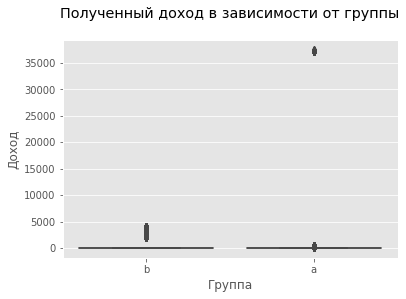

In [115]:
sns.boxplot(x = 'testgroup', y = 'revenue', data = df)
plt.title('Полученный доход в зависимости от группы\n')
plt.xlabel('Группа')
plt.ylabel('Доход')

Видим, что все платёжные действия пользователей интерпретируются как выбросы в данных. Такая концепция нелогична.

С помощью критерия согласия Пирсона проверим, значимы ли различия между группами в количестве платящих пользователей. H0 =  между ними нет разницы. H1 = разница есть.

In [116]:
#добавим к исходным данным колонку, которую заполним значениями 'not_paid', 'paid' в зав-ти от того, был доход с юзера или нет
df['pay'] = np.where(df['revenue']==0, 'not_paid', 'paid')

In [117]:
df

,user_id,revenue,testgroup,pay
0,1,0,b,not_paid
1,2,0,a,not_paid
2,3,0,a,not_paid
3,4,0,b,not_paid
4,5,0,b,not_paid
...,...,...,...,...
404765,404766,0,a,not_paid
404766,404767,0,b,not_paid
404767,404768,231,a,paid
404768,404769,0,a,not_paid


In [118]:
#создаём таблицу сопряженности
pd.crosstab(df.pay, df.testgroup)

testgroup,a,b
pay,,
not_paid,200175,200862
paid,1928,1805


In [119]:
from scipy.stats import chi2_contingency, chi2 

In [120]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.pay, df.testgroup))

In [121]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [122]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Критерий χ2 превышает критическое значение (p-value < 0.05), значит мы можем опровергнуть H0 и утверждать, что между тестовыми группами и числом платящих пользователей есть разница.

###### Контрольная группа показала значимые различия по количеству платящих пользователей.

Объявим функцию, которая позволит проверять гипотезу с помощью бутстрапа

In [129]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1),len(data_column_2)])
    boot_data = []
    for i in (range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
       
        boot_data.append(statistic(samples_1 - samples_2))# mean() - применяем статистику
    
    pd_boot_data = pd.DataFrame(boot_data)
    
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    return {"p_value" : p_value}

In [130]:
get_bootstrap(
    test.revenue, # числовые значения первой выборки
    control.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'p_value': 0.5444299548237441}

#### pvalue > 0.05, соответственно существенных различий в средних размерах выручки на одного пользователя  у тестовой и контрольной групп не обнаружено.

Таким образом, у нас нет оснований отвергать нулевую гипотезу о равенстве среднего дохода на пользователя в тестовой и контрольной группе.

Но что будет, если сравнивать только внутри платящих групп?

По факту у нас будут 2 выборки неравного размера (мы выше это доказали, что разница значительна). Тогда в качестве статического оценщика тоже лучше всего выбрать бутстрап.

In [131]:
#записываем в отдельный дф данные только по платящим пользователям
paid = df.query('revenue != 0')

In [132]:
# и выделяем для удобства дф с данными только по контрольной группе
control_paid = paid.query("testgroup == 'a'")

In [133]:
control_paid.revenue.sum()

5136189

In [134]:
# и выделяем для удобства дф с данными только по тестовой группе
test_paid = paid.query("testgroup == 'b'")

In [135]:
test_paid.revenue.sum()

5421603

In [136]:
#применяем функцию 
get_bootstrap(
    test_paid.revenue, # числовые значения первой выборки
    control_paid.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'p_value': 0.10956344277412135}

#### Мы видим, что даже сравнивая только внутри платёжных групп, pvalue > 0.05,  а это значит, что существенных различий в средних размерах выручки на одного пользователя у тестовой и контрольной групп не обнаружено и у нас нет оснований считать лучшим старое или новое акционное предложение.

Давайте посчитаем Средний доход на платящего пользователя ARPPU (average revenue per paying user)

In [137]:
arppu_a = control_paid.revenue.sum() / control_paid.user_id.nunique()
arppu_a

2663.9984439834025

In [138]:
arppu_b = test_paid.revenue.sum() / test_paid.user_id.nunique()
arppu_b

3003.6581717451522

Мы видим разницу, при тестовом наборе предложений средний доход на платящего пользователя оказался выше, чем у контрольного.

Но, если проанализировать, получается, что выше, когда мы применили бутстрап только для платящих групп, мы по факту выяснили, что полученная разница между средним доходом у контрольной и тестовой групп (платящих) не является статистически значимой и, можно сказать, была случайностью.

In [139]:
#А если применить бутстрап, но с оценкой медианы (гипотезу он также будет проверять другую)
get_bootstrap(
    test_paid.revenue, # числовые значения первой выборки
    control_paid.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'p_value': 0.0}

При оценки медианы pvalue сильно меньше 0.05, а это значит, что различия есть. 

In [140]:
test_paid.revenue.median()

3022.0

In [141]:
control_paid.revenue.median()

311.0

Выходит, что половина платящих пользователей в тестовой группе потратили сильно больше, чем половина платящих пользователей в контрольной группе.

##### Вывод:

##### В ходе анализа не удалось выявить статистически значимых различий у тестовой и контрольной группы по ARPU, и даже по ARPPU.
##### Единственное, что удалось доказать - это то, что контрольная группа показала значимые различия по количеству платящих пользователей (в контрольной группе их оказалось больше).
##### Однако, тот же бутстрап, но уже по медиане позволяет нам говорить о разнице двух платящих групп (в тестовой половина пользователей потратит больше).

##### Ввиду того, что никаких дополнительных данных для анализа у нас нет, то можно сделать вывод, что новый набор тестовых предложений уменьшит количество платящих пользователей, но заставит их платить больше. Если для бизнеса это важно, то можно использовать новый набор акц. предложений.

## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Сперва разберемся с первым вопросом.

Такими метриками могут быть:

    -количество игроков, которые впервые приняли участие в тематическом событии (новые игроки регистрируются каждый месяц, но не всегда каждый из них готов принять участие в тематическом событии) в сравнении с предыдущими месяцами;
    - количество игроков, которые уже ранее принимали участие в других тематических событиях с разбивкой на тех, кто успешно прошёл уровни и получил бонусы и тех, кто нет (покажет, на сколько эти тематические события нравятся самим игрокам и бонусы для них ценны);
    - количество игроков, успешно прошедших ряд заявленных уровней за определенное время в сравнении с предыдущими месяцами;
    - среднее кол-во полученнных монет или бонусов на игрока в сравнении с предыдущими месяцами (предполагается, что чем быстрее и успешнее игрок проходит уровень, тем больше монет или бонусов он за него получит);
    - среднее время прохождения ряда уровней (в сравнении с месяцами, в которых в тематическом событии были задействованы такие же уровни, либо уровни, сложность которых равнозначна сложностям уровней этого месяца для справедливого сравнения);
    - в условии ничего не сказано, но будем считать, что в игре есть возможность монетизации (игроки могуть покупать предметы для сада и иные плюшки, которые помогут быстрее и успешнее пройти уровень). Поэтому будет важно посчитать revenue, arpu, arppu, retention, churn rate для данного тематического события. Если на тематическое событие была запущена отдельная рекламная компания, то будет важно посчитать ROI.

Что касается второго вопроса - изменится ли набор метрик оценки результата, если при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад, то да, кое-что нужно будет посмотреть дополнительно.

В таком случае кроме вышеуказанных метрик нужно будет отследить:
    
    - какой процент игроков, находящихся на высоких уровнях (будем считать, что в игре всего 100 уровней, высоким считается уровень, начиная с 50-го), приняли участие в тематическом событии в сравнении с предыдущими месяцами (можно также посмотреть статистику по каждому конкретному высокому уровню). Т.к. уровни и их сложность высокие, привлекательность призов и бонусов должна быть также значительной, чтобы игроки могли пойти на риск;
    - выше уже были указаны такие kpi как evenue, arpu, arppu, retention, churn rate, но в данном случае их также будет очень важно посчитать, т.к. если у нас и сократилось кол-во участников тематического события ввиду его условий и высокого риска откатиться назад, то, несмотря на это, мы можем получить большее кол-во платящих пользователей или просто больший доход от мероприятия, т.к. те, кто рискнули и проиграли, могут более охотно покупать предметы для сада, чтобы как можно быстрее вернуться на тот уровень, на котором они были изначально. А может быть в игре даже будет предусмотрена опция платного возврата на уровень, на котором находились игроки до неудачного прохождения тематического события, чтобы сэкономить время и игроку не пришлось снова проходить то, что он уже проходил. Как кнопка возврата анкеты, которую пользователь смахнул влево в Тиндер Голд.

## Финальные выводы:

В рамках выполнения данной работы были выполнены следующие задания:

1. Была написана функция для подсчёта retention rate мобильной игры. Работа функции была протестирована на семпле данных (использованы данные с регистациями за август 2020-го года). В ходе анализа была обнаружена аномалия 1-го дня, т.к. показатель D1 Retention очень маленький (среднее значение D1 Retention по всем когортам - 2.02%), а в последующие несколько дней в среднем наблюдается небольшой рост активности пользователей. Анализ динамики по остальным дня показывает, что показатель retention  снижается с каждым днём. "Лидирующую" по показателю retention когорту выделить не удалось, но это в данном случае не так важно, т.к. в целом можно утверждать, что пользователям, зарегистрированным в августе 2020-го года, игра была неинтересна и удержать пользователей не удалось, т.к. средний показатель D1 Retention не достиг даже 20%.

2. На основе имеющихся данных о результатах A/B тестирования наборов акционных предложений было определено, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение. Были протестированы гипотезы о равенстве ARPU и ARPPU у тестовой и контрольной группы, и статистически значимых различий обнаружено не было (в кач-ве статистического оценщика был выбран бутстрап). Однако, тот же бутстрап, но уже по медиане позволил нам говорить о разнице двух платящих групп (в тестовой половина пользователей потратит гораздо больше, чем в контрольной).
Ввиду того, что ещё каких-либо дополнительных данных для анализа у нас нет, то можно сделать вывод, что новый набор тестовых предложений уменьшит количество платящих пользователей, но заставит их платить больше. Если для бизнеса это важно, то можно использовать новый набор акц. предложений.

3. Были предложены метрики для оценки результатов последнего прошедшего тематического события в игре Plants & Gardens. Автор предложил как использовать продуктовые метрики, так и бизнес, margin метрики в сравнеии с аналогичными метриками прошлых событий.

#### Благодарю за внимание!